Лабораторная работа 4.

Прогнозирование непрерывной переменной (задача регрессионного анализа). Манипулирование признаками. Сокращение размерности.

1. Выбрать подходящую таблицу данных (должна содержать числовые и категориальные переменные) с непрерывной целевой переменной. Временно убрать категориальные признаки. Построить линейную регрессию.

2. Построить решение методом бустинга (подобрать оптимальные параметры сложности). Сравнить с линейной регрессией.

3. Применить one hot и target encoding для категориальных признаков (взять данные, где такие признаки есть). Сравнить точность.

4. Визуализировать объекты (не обязательно для той же таблицы) в пространстве главных компонент.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

In [ ]:
# Data Preparation
DF = sns.load_dataset('penguins').dropna()
TARGET = 'body_mass_g'
CAT = DF.select_dtypes(include=['object', 'category']).columns
NUM = DF.select_dtypes(include=np.number).columns.drop(TARGET)

# Логарифмирование целевой переменной
y = np.log(DF[TARGET])


[Part 1] Linear Regression (Numeric Only):
  R²: 0.754
  MAE: 0.073
  RMSE: 0.089


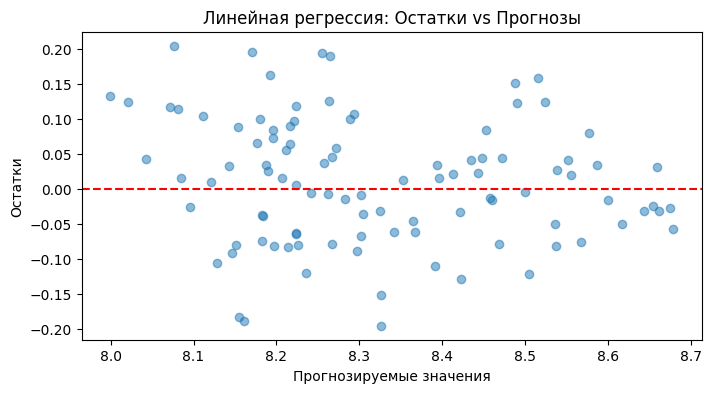

In [ ]:
# 1: Linear Regression (Numeric)
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    DF[NUM], y, test_size=0.3, random_state=42
)

lr = LinearRegression()
lr.fit(X_train_num, y_train_num)
y_pred_lr = lr.predict(X_test_num)

print("\n[Part 1] Linear Regression (Numeric Only):")
print(f"  R²: {r2_score(y_test_num, y_pred_lr):.3f}")
print(f"  MAE: {mean_absolute_error(y_test_num, y_pred_lr):.3f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_num, y_pred_lr)):.3f}")

# Визуализация остатков
plt.figure(figsize=(8,4))
plt.scatter(y_pred_lr, y_test_num - y_pred_lr, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Линейная регрессия: Остатки vs Прогнозы')
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.show()


[Part 2] Gradient Boosting Parameter Tuning:
n_estimators=50: CV R²=0.780
n_estimators=100: CV R²=0.774
n_estimators=150: CV R²=0.762
n_estimators=200: CV R²=0.751
n_estimators=250: CV R²=0.741

Gradient Boosting Results:
  R²: 0.823
  MAE: 0.060
  RMSE: 0.076


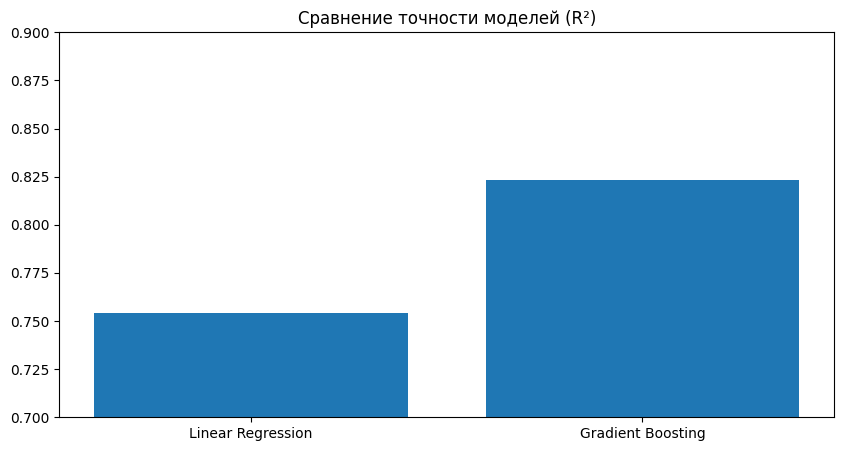

In [ ]:
 #2: Gradient Boosting + Parameter Tuning
 # Подбор оптимального количества деревьев
n_estimators_list = [50, 100, 150, 200, 250]
best_score = -np.inf
best_n = 50

print("\n[Part 2] Gradient Boosting Parameter Tuning:")
for n in n_estimators_list:
    gbr = GradientBoostingRegressor(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    score = np.mean(cross_val_score(gbr, X_train_num, y_train_num, cv=5, scoring='r2'))
    print(f"n_estimators={n}: CV R²={score:.3f}")
    if score > best_score:
        best_score = score
        best_n = n

# Обучение лучшей модели
gbr = GradientBoostingRegressor(
    n_estimators=best_n,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train_num, y_train_num)
y_pred_gbr = gbr.predict(X_test_num)

print("\nGradient Boosting Results:")
print(f"  R²: {r2_score(y_test_num, y_pred_gbr):.3f}")
print(f"  MAE: {mean_absolute_error(y_test_num, y_pred_gbr):.3f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_num, y_pred_gbr)):.3f}")

# Сравнение с линейной регрессией
plt.figure(figsize=(10,5))
plt.bar(['Linear Regression', 'Gradient Boosting'],
        [r2_score(y_test_num, y_pred_lr),
         r2_score(y_test_num, y_pred_gbr)])
plt.title('Сравнение точности моделей (R²)')
plt.ylim(0.7, 0.9)
plt.show()


# 3: Categorical Encoding Methods

In [ ]:
# Разделение данных с категориальными признаками
X_full = DF.drop(columns=[TARGET])
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y, test_size=0.3, random_state=42
)

# Метод 1: One-Hot Encoding (get_dummies)
X_train_oh = pd.get_dummies(X_train_full, columns=CAT)
X_test_oh = pd.get_dummies(X_test_full, columns=CAT).reindex(
    columns=X_train_oh.columns, fill_value=0
)

# Метод 2: Target Encoding (ручная реализация)
def manual_target_encoding(X_train, y_train, X_test, cat_cols):
    X_train_te = X_train[NUM].copy()
    X_test_te = X_test[NUM].copy()

    for col in cat_cols:
        # Вычисляем средние значения по обучающей выборке
        means = X_train[[col]].join(y_train).groupby(col)[y_train.name].mean()

        # Применяем к train и test
        X_train_te[f'{col}_te'] = X_train[col].map(means)
        X_test_te[f'{col}_te'] = X_test[col].map(means)

        # Заполняем пропуски (новые категории) глобальным средним
        global_mean = y_train.mean()
        X_train_te[f'{col}_te'].fillna(global_mean, inplace=True)
        X_test_te[f'{col}_te'].fillna(global_mean, inplace=True)

    return X_train_te, X_test_te

X_train_te, X_test_te = manual_target_encoding(
    X_train_full, y_train_full, X_test_full, CAT
)

print(X_train_te.head())

     bill_length_mm  bill_depth_mm  flipper_length_mm  species_te  island_te  \
27             40.5           17.9              187.0    8.201201   8.440733   
292            48.2           15.6              221.0    8.528952   8.440733   
302            47.4           14.6              212.0    8.528952   8.440733   
62             37.6           17.0              185.0    8.201201   8.440733   
181            52.8           20.0              205.0    8.217086   8.212579   

       sex_te  
27   8.240756  
292  8.408314  
302  8.240756  
62   8.240756  
181  8.408314  


<ipython-input-7-b2e5915ae190>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_te[f'{col}_te'].fillna(global_mean, inplace=True)
<ipython-input-7-b2e5915ae190>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

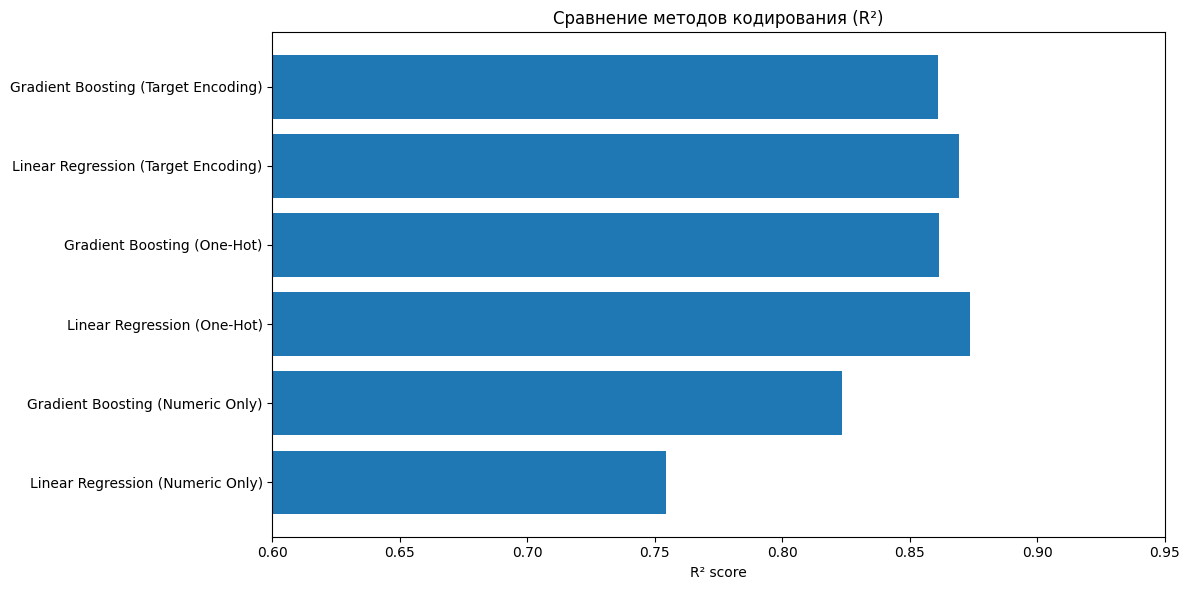

In [ ]:
# Сравнение методов кодирования
results = {}
models = {
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=best_n, random_state=42)
}

for encoding, (X_tr, X_te) in {
    'Numeric Only': (X_train_num, X_test_num),
    'One-Hot': (X_train_oh, X_test_oh),
    'Target Encoding': (X_train_te, X_test_te)
}.items():
    for model_name, model in models.items():
        model.fit(X_tr, y_train_full)
        pred = model.predict(X_te)
        key = f"{model_name} ({encoding})"
        results[key] = r2_score(y_test_full, pred)

# Визуализация результатов
plt.figure(figsize=(12,6))
plt.barh(list(results.keys()), list(results.values()))
plt.title('Сравнение методов кодирования (R²)')
plt.xlim(0.6, 0.95)
plt.xlabel('R² score')
plt.tight_layout()
plt.show()

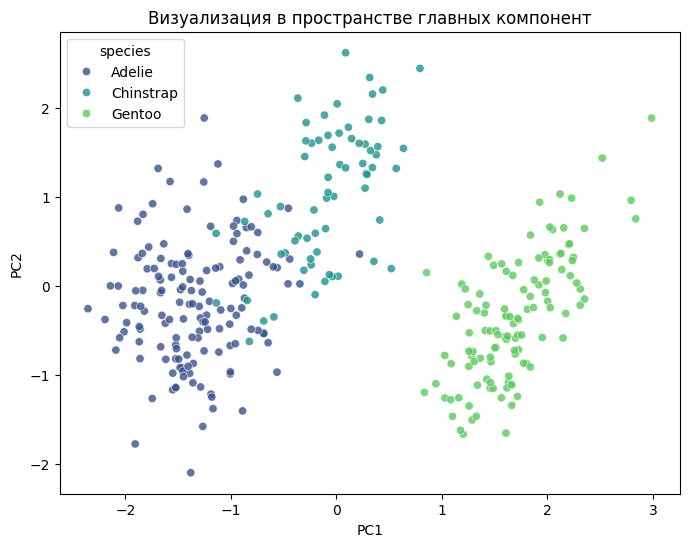

In [ ]:
# 4: PCA Visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(DF[NUM])
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=principal_components[:,0],
    y=principal_components[:,1],
    hue=DF[CAT[0]].values,
    palette='viridis',
    alpha=0.8
)
plt.title('Визуализация в пространстве главных компонент')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title=CAT[0])
plt.show()